In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.decomposition import PCA

In [101]:
def impute_median(df):
    """
    Function to impute missing values with median

    Args:
        df (pandas dataframe): dataframe

    Returns:
        df (pandas dataframe): dataframe with missing values imputed
    
    """
    null_val = (df.isnull() # check for null values
                    .sum() # sum of null values
                    .sort_values(ascending=False) # sort values in descending order
                    .reset_index()) # reset index
    null_val.columns = ['attribute','count'] # rename columns

    # iterate through df to impute median
    for index,row in null_val.iterrows():
        if row['count'] > 0: # if null values exist
            print(f'{row["attribute"]} has {row["count"]} null values') # print attribute and count
            df.loc[(df[row['attribute']].isnull()==True),row['attribute']]=df[row['attribute']].median() # impute median
        else:
            continue
    return df

def log_transform(df, cols):
    """
    Function for Log transformation

    Args:
        df (pandas dataframe): dataframe
        cols (list): list of columns to be transformed

    Returns:
        df (pandas dataframe): dataframe with log transformed columns
    
    """
    for col in cols:
        try:
            df[col] = np.log(1 + df[col])
        except:
            print(f'{col} unsuccessful')
    
    return df


## Outlier Removal 
def iqr_outlier_removal(df,attribute_list):
    """
    Function for IQR outlier removal

    Args:
        df (pandas dataframe): dataframe
        attribute_list (list): list of columns to be transformed    

    Returns:
        df (pandas dataframe): dataframe with IQR outlier removed
    
    """
    def identify_outlier(df,column):
        """Identify outlers via IQR"""
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3-Q1
        upper = Q3 + 1.5 * IQR
        lower = Q1 - 1.5 * IQR
        ls = df.index[(df[column]< lower) | (df[column]> upper)] #returns list of indices for outliers
        return ls 

    def extract_outliers (df, attribute_list):
        """Function to extract identifed outliers"""
        outliers = [] #Initialise empty list

        for column in df[attribute_list].columns:
            outliers.extend(identify_outlier(df,column))        
        return outliers
        
    def remove_outliers(df,ls):
        "Remove outliers"
        ls = sorted(set(ls))
        df = df.drop(ls)
        return df

    outlier_index_list = extract_outliers(df,attribute_list)
    outliers_removed = remove_outliers(df,outlier_index_list)
    return outliers_removed

def apply_pca (data, n_components = 2):
    """
    Function to apply PCA to reduce dimensions
    
    Args:
        data [dataframe]: data file for user attributes
        n_components [int]: number of components in PCA, default as 2
    Returns:
        pca_df [dataframe]: data file with principal components
        pca_fit [dataframe]: fitted PCA
    """

    pca = PCA(n_components = n_components)     #PCA
    pca_fit = pca.fit_transform(data) #Reducing the dimensions of the data
    pca_df = pd.DataFrame(pca_fit,  #Dataframe for first 2 PCs
                            columns = ['PC1', 'PC2'],
                            index=data.index.copy())  # set yara_user_id as index
                            

    return pca_df, pca

In [102]:
df = pd.read_csv('../data/CC_GENERAL.csv')

data = df.set_index(['CUST_ID']) # set index to CUST_ID


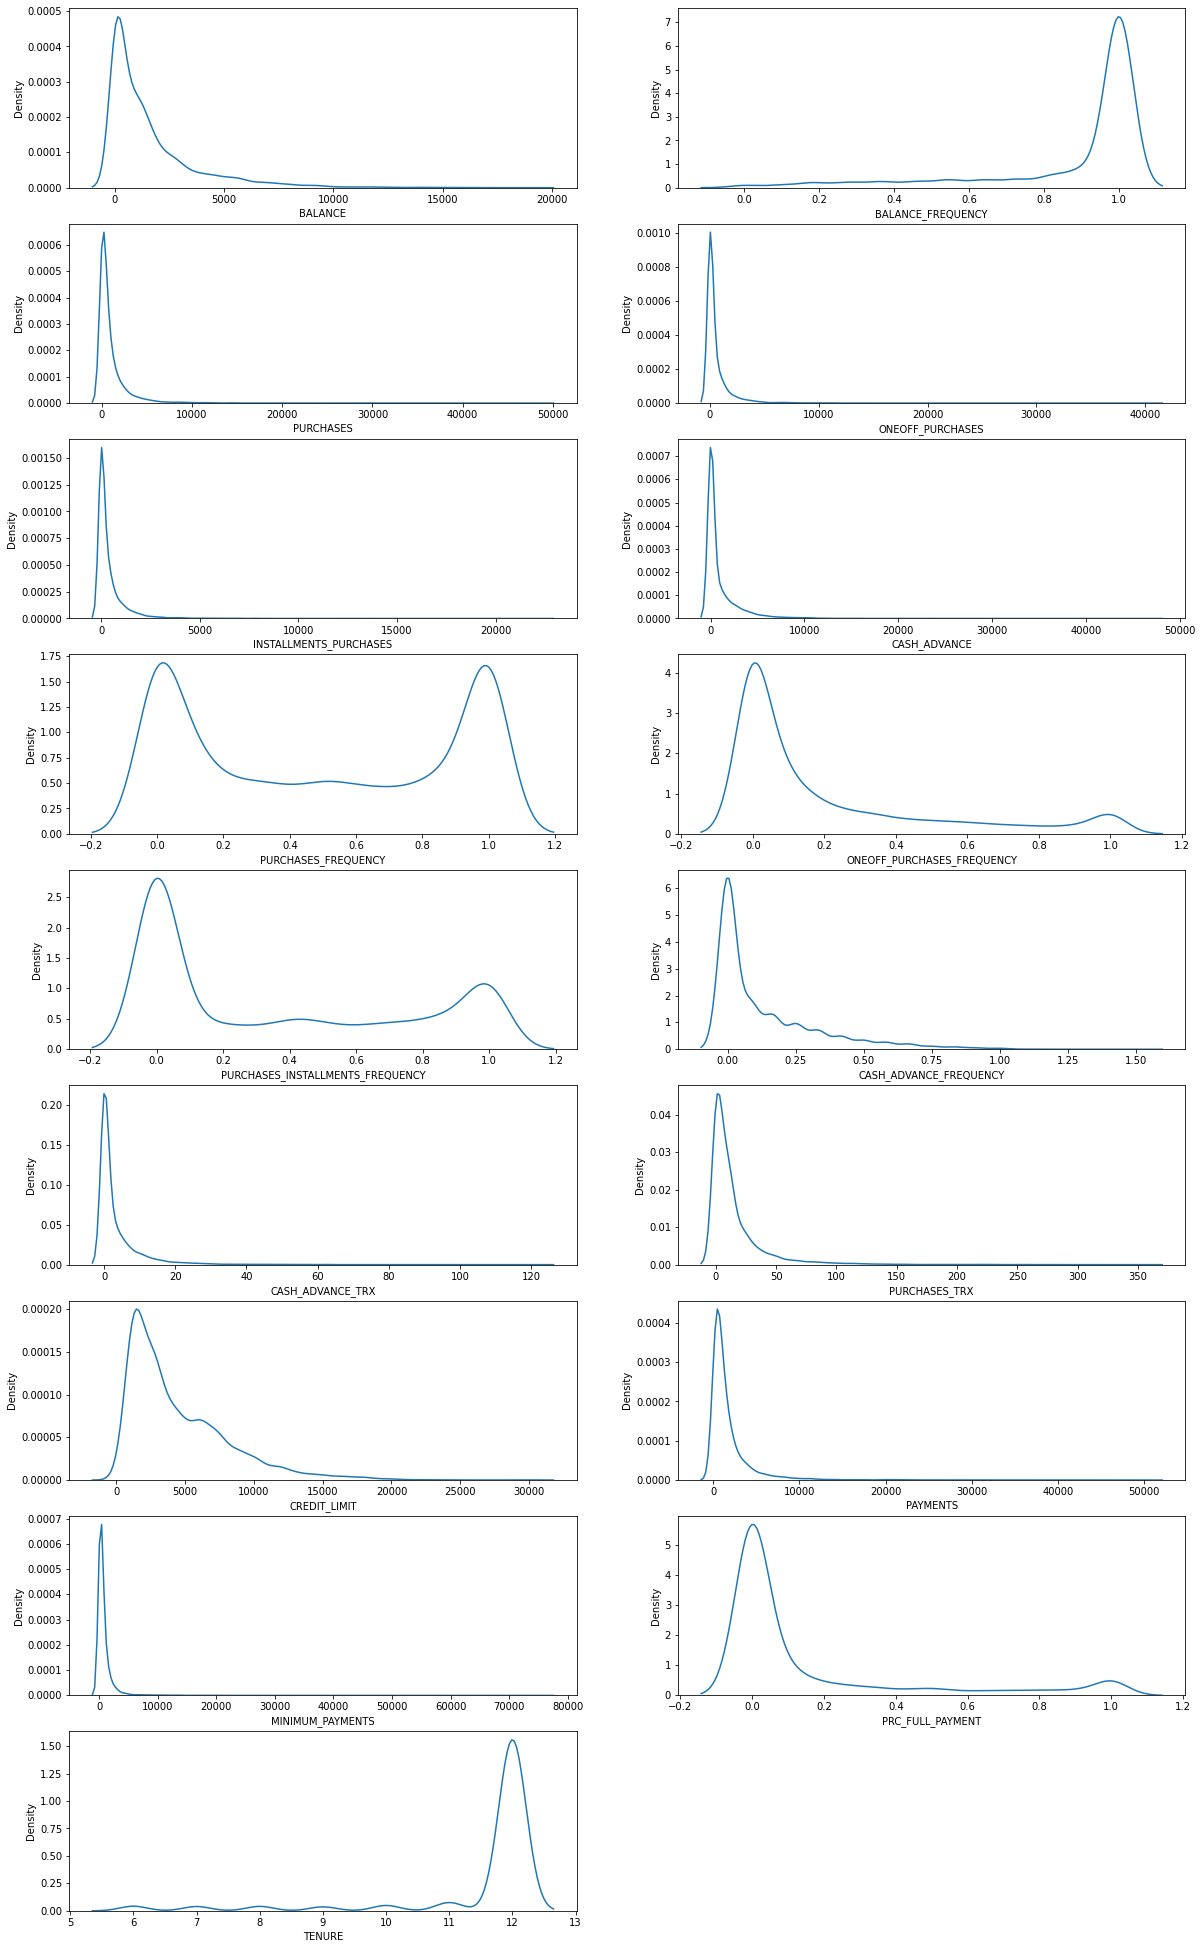

In [103]:
plt.figure(figsize=(20,35))
for i, col in enumerate(data.columns):
    if data[col].dtype != 'object':
        ax = plt.subplot(9, 2, i+1)
        sns.kdeplot(data[col], ax=ax)
        plt.xlabel(col)
        
plt.show()

From the distribution plot, the data is heavily skewed and varied, so we will require further transformation. In this case, I intend to handle the skewness here as it will help the model perform better during the clustering phase

But before we do that, let's do something with missing values first. Since the data is heavily skewed, using median instead of mean would be more appropriate. Median gives us a better estimation of central tendency.  

In [104]:
df_median_imputed = impute_median(data) # impute missing values with median

MINIMUM_PAYMENTS has 313 null values
CREDIT_LIMIT has 1 null values


In [105]:
# log transform
df_log_transformed = log_transform(df_median_imputed, list(df_median_imputed.columns))

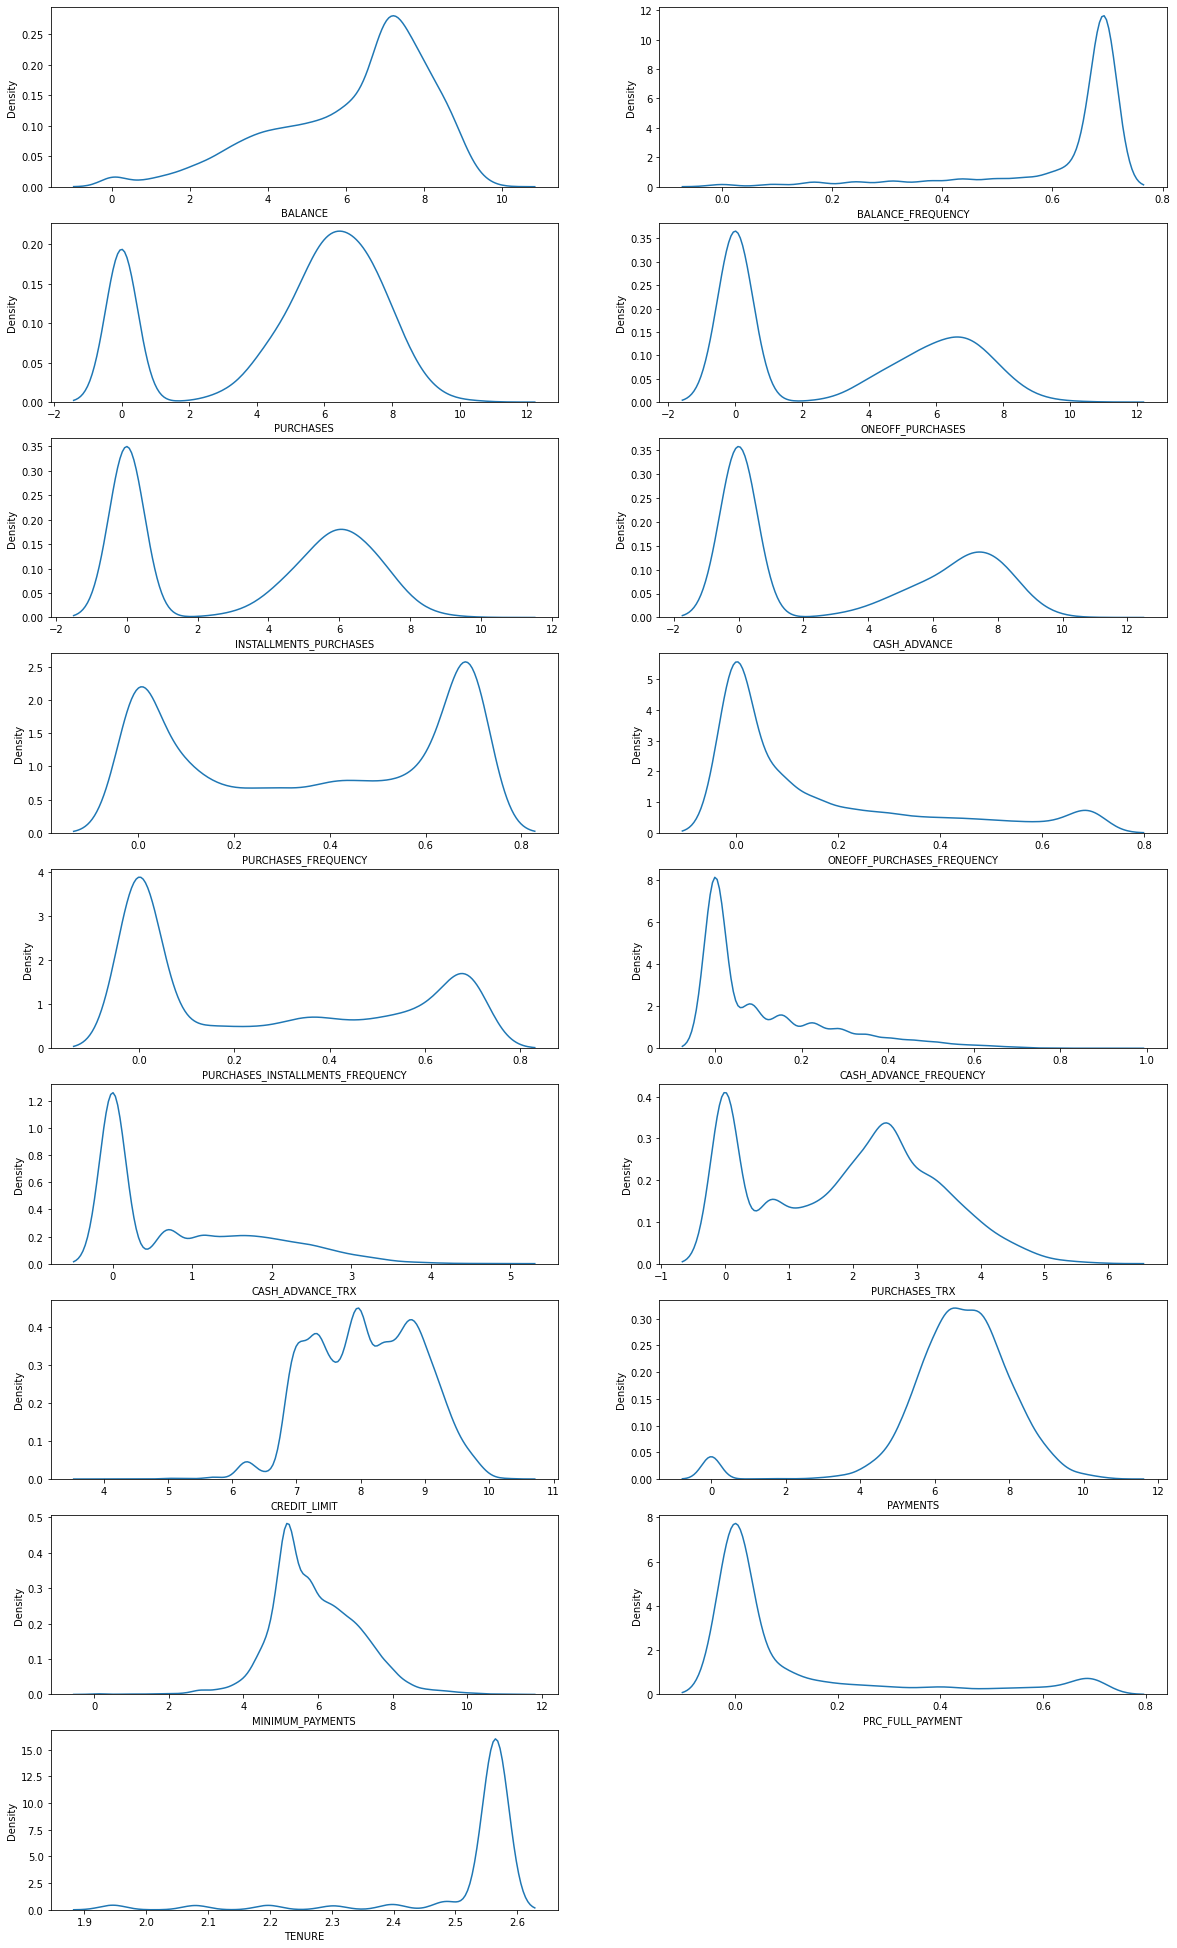

In [106]:
plt.figure(figsize=(20,35))
for i, col in enumerate(df_log_transformed.columns):
    if df_log_transformed[col].dtype != 'object':
        ax = plt.subplot(9, 2, i+1)
        sns.kdeplot(df_log_transformed[col], ax=ax)
        plt.xlabel(col)
        
plt.show()

The distribution is not ideal but it looks alot better than the before. This should be sufficient in helping the cluster model later on

Let's explore the dataset further using a boxplot to undestand how the data points are distributed and check for outliers.

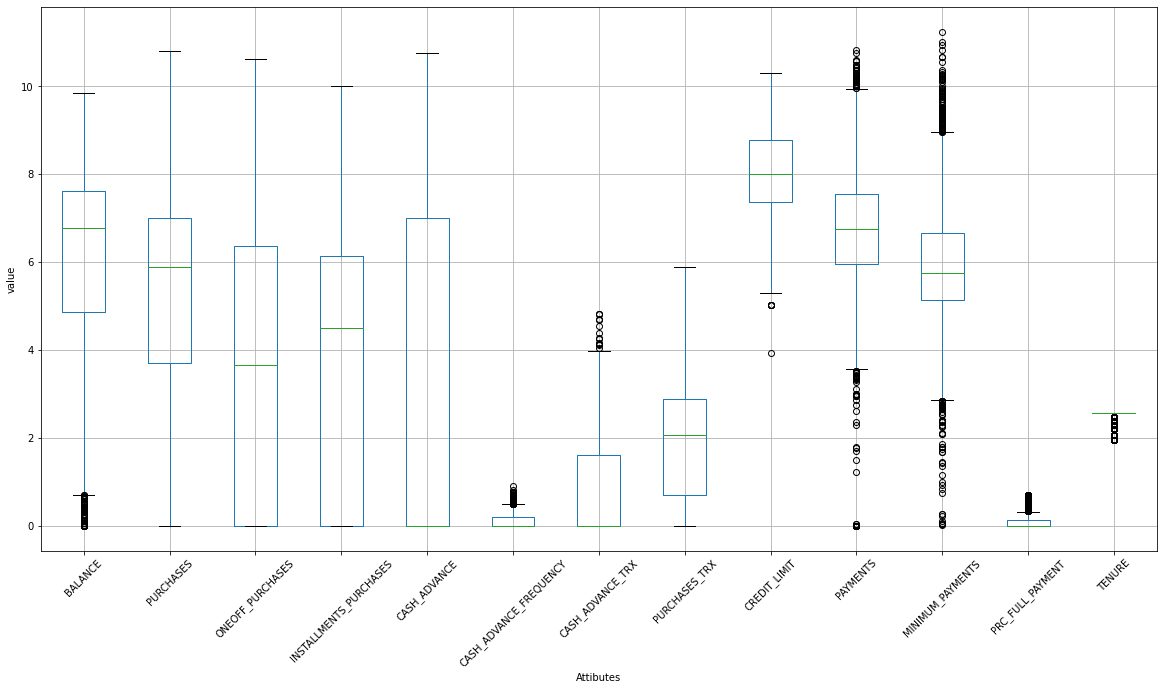

In [108]:
df_log_transformed.drop(['BALANCE_FREQUENCY','PURCHASES_FREQUENCY','ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY'],axis=1).boxplot(figsize=(20,10));
plt.xticks(rotation=45);
plt.ylabel('value');
plt.xlabel('Attibutes');

We can see that are some outliers. Lets remove those using Interquartile Range. 

In [109]:
# list of attributes to be removed
unwanted_ele = ['CUST_ID']
# 
attribute_list = [ele for ele in list(df_log_transformed.columns) if ele not in unwanted_ele]

# remove outliers
df_without_outliers = iqr_outlier_removal(df_log_transformed,attribute_list)


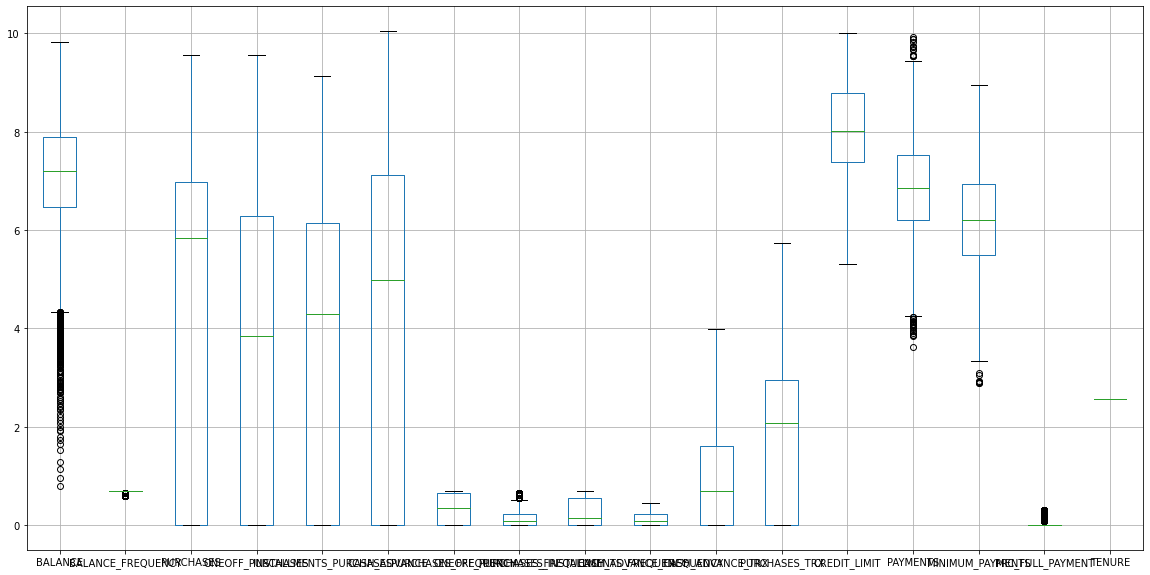

In [110]:
df_without_outliers.boxplot(figsize=(20,10));

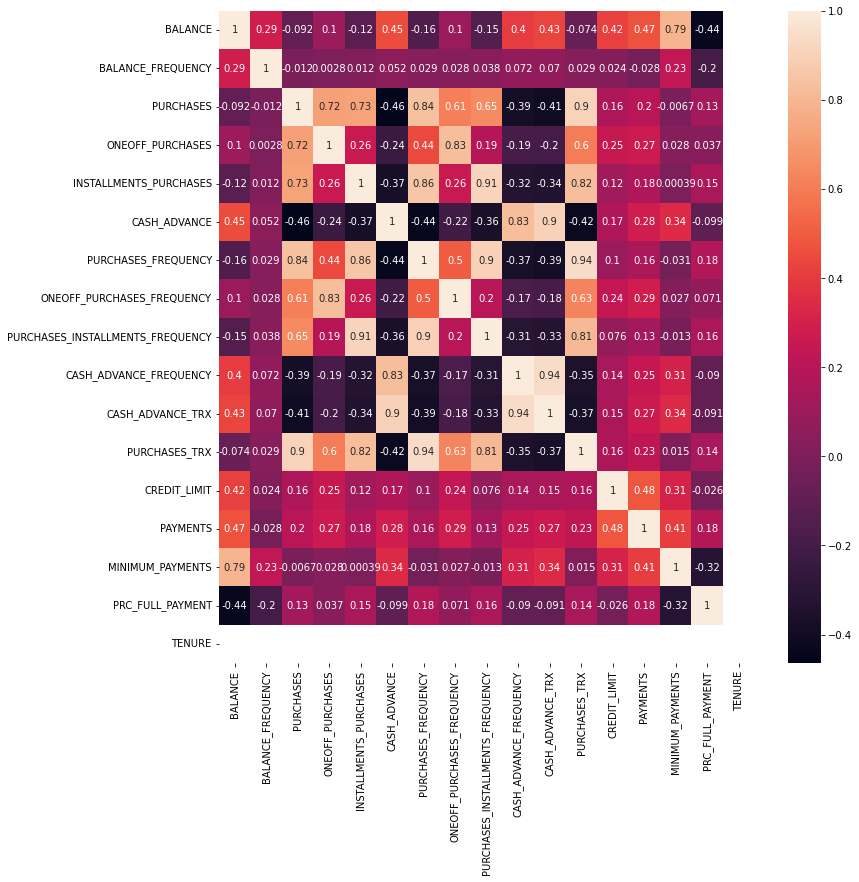

In [111]:
plt.figure(figsize=(12,12))
sns.heatmap(df_without_outliers.corr(), annot=True)
plt.show()

The outliers look alot better than before now. This preprocessed data can now be 

In [130]:
data_pca, pca = apply_pca(df_without_outliers)

In [131]:
data_pca

,PC1,PC2
CUST_ID,,
C10001,0.977727,-6.019202
C10002,-8.378747,1.501084
C10005,-1.123715,-4.079621
C10006,3.731336,-3.660419
C10008,2.729357,-4.185211
...,...,...
C18980,3.230708,-5.049649
C18986,4.963817,-3.152891
C18993,1.397357,1.572474
